<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Noise_speech_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tqdm
# !pip install pydub

In [ ]:
# !wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/fr.tar.gz

In [5]:
# !tar -xf fr.tar.gz

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import stft, istft
import glob
from pydub import AudioSegment
from tensorflow.keras import models, layers
from tqdm.notebook import tqdm

In [6]:
list_mp3_files = glob.glob("./cv-corpus-5.1-2020-06-22/fr/clips/*.mp3")
train_mp3_data = list_mp3_files[:-2000]
test_mp3_data = list_mp3_files[-2000:]
print(len(train_mp3_data))

448077


In [7]:
def build_model():

    model = models.Sequential()
    model.add(layers.Dense(1000, activation='relu', input_shape=(501,)))
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(501, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    return model

In [8]:
def reshape_data(samples, labels):

    shapes = np.shape(samples)

    samples = np.transpose(samples)
    labels = np.transpose(labels)

    samples = np.reshape(samples, (1, shapes[0]*2000, 501))
    labels = np.reshape(labels, (1, shapes[0]*2000, 501))

    samples = np.squeeze(samples)
    labels = np.squeeze(labels)

    return samples, labels

In [9]:
def add_noise(array_sound):
          
    max_1 = max(array_sound)
    noise = np.random.normal(0, 0.75, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = max(array_sound_noisy)
    array_sound_noisy *= max_1/max_2

    return array_sound_noisy

In [10]:
def load_and_convert_data_with_label(train_mp3_data):

    labels = []
    samples = []
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        # normalize array
        mean = np.mean(array_sound, axis=0)
        std = np.std(array_sound)
        array_sound -= mean
        array_sound /= std

        # convert label to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        original_abs_stft = np.abs(array_stft)

        # padding 
        pad_length = 2000 - np.shape(original_abs_stft)[1]
        original_abs_stft = np.pad(original_abs_stft, ((0,0), (0, pad_length)))

        # add random noise
        array_sound_noisy = add_noise(array_sound)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)

        # padding 
        pad_length = 2000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))

        label_abs_stft = np.where(abs(sample_abs_stft-original_abs_stft) > sample_abs_stft/2, 0, 1)

        labels.append(label_abs_stft)
        samples.append(sample_abs_stft)
        i+=1

    samples = np.array(samples)
    labels = np.array(labels)
    return samples, labels, mean, std

In [ ]:
nb_epoch = 5

train_loss = []
train_acc = []
val_loss = []
val_acc = []

model = build_model()

for k in range(0, len(list_mp3_files)//200):

    train_mp3_data = list_mp3_files[k*200:(k+1)*200]

    print("\n CONVERTING DATA \n")
    samples, labels = load_and_convert_data_with_label(train_mp3_data)
    # print(np.shape(samples))

    print("\n RESHAPING DATA \n")
    samples, labels = reshape_data(samples, labels)

    print("\n FITTING MODEL \n")
    history_part = model.fit( samples, labels, epochs=50, batch_size=2000, validation_split=0.15, shuffle=True)

    history_dict_part = history_part.history
    train_acc_values_part = history_dict_part['acc']
    train_loss_values_part = history_dict_part['loss']
    val_acc_values_part = history_dict_part['val_acc']
    val_loss_values_part = history_dict_part['val_loss']
  
    train_loss.append(train_loss_values_part)
    train_acc.append(train_acc_values_part)
    val_loss.append(val_loss_values_part)
    val_acc.append(val_acc_values_part)


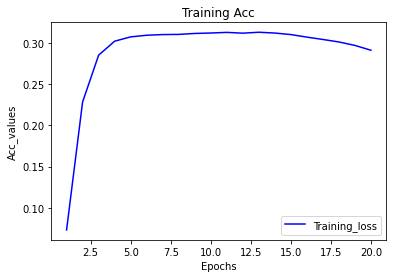

In [15]:
epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'b', label='Training_acc')
plt.plot(epochs, val_acc, 'bo', label='Validation_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_values')
plt.legend()

plt.show()

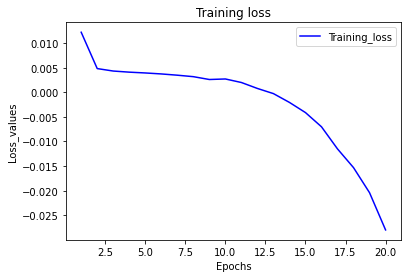

In [17]:
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'b', label='Training_loss')
plt.plot(epochs, val_loss, 'bo', label='Validation_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss_values')
plt.legend()

plt.show()

In [11]:
def load_and_convert_data(train_mp3_data, add_noise_to_sample=False):

    samples = []
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        # normalize array
        mean = np.mean(array_sound, axis=0)
        std = np.std(array_sound)
        array_sound -= mean
        array_sound /= std

        if add_noise_to_sample:
            array_sound = add_noise(array_sound)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)

        # padding 
        pad_length = 2000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))

        samples.append(sample_abs_stft)
        i+=1

    samples = np.array(samples)

    return samples, mean, std

In [ ]:
list_files = ["./original/common_voice_fr_18157595.mp3"]
samples, mean, std = load_and_convert_data(list_files, True)
denoised_array_sound = denoising(samples, mean, std)

# save reconverted sound to wav
path_to_wav_file = './denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, desnoised_array_sound)
    

In [ ]:
def denoising(samples, mean, std):
    
    # load model

    # predict and apply mask
    mask = model.predict(samples)
    denoised_sound_stft = samples*mask

    # convert back to sound from F_T_space
    t, desnoised_array_sound = istft(denoised_sound_stft, fs=48000, nperseg=1000)
    desnoised_array_sound = np.array(desnoised_array_sound)
    desnoised_array_sound *= std
    desnoised_array_sound += mean
    desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    return desnoised_array_sound





In [8]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [32]:
# load mp3 sound to array
mp3_sound = AudioSegment.from_mp3("./original/common_voice_fr_18157595.mp3")
array_sound_mp3 = np.array(mp3_sound.get_array_of_samples())

# save original to wav
path_to_wav_file = './noised/noised_sound0.wav'
write(path_to_wav_file, 48000, array_sound_mp3)

# save to mp3 from wav
mp3_sound_save = AudioSegment.from_wav(path_to_wav_file)
mp3_sound_save.export('./original/noised_sound0.mp3', format='mp3')

# load wav sound to array
samplerate, wav_sound = read("./noised/noised_sound0.wav")
array_sound_wav = np.array(wav_sound, np.float64)

# # plot
# plt.plot([i for i  in range(len(array_sound_wav))], array_sound_wav, 'b')
# plt.show()
# plt.plot([i for i  in range(len(array_sound_mp3))], array_sound_mp3, 'r')
# plt.show()


In [ ]:
for i, path_to_mp3_file in enumerate(list_mp3_files[1:2]):

    # load mp3 sound to array
    loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
    array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

    # normalize array
    mean = np.mean(array_sound, axis=0)
    std = np.std(array_sound)
    array_sound -= mean
    array_sound /= std

    # add random noise
    max_1 = max(array_sound)
    noise = np.random.normal(0, 0.75, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = max(array_sound_noisy)
    array_sound_noisy *= max_1/max_2
    
    # save original to wav
    array_sound_noisy_to_save = array_sound_noisy * std
    array_sound_noisy_to_save += mean
    array_sound_noisy_to_save = np.array(array_sound_noisy_to_save, np.int16)
    path_to_wav_file = './noised/noised_sound0.wav'
    write(path_to_wav_file, 48000, array_sound_noisy_to_save)

    # plot original and noisy
    plt.plot([i for i  in range(len(array_sound))], array_sound_noisy, 'r')
    plt.plot([i for i  in range(len(array_sound))], array_sound, 'b')
    plt.show()

    # convert sound to to F_T_space
    f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
    array_abs_stft = np.abs(array_stft)

    plt.pcolormesh(t, f, array_abs_stft)
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

    # convert back to sound from F_T_space
    t, desnoised_array_sound = istft(array_stft, fs=48000, nperseg=1000)
    desnoised_array_sound = np.array(desnoised_array_sound)
    desnoised_array_sound *= std
    desnoised_array_sound += mean
    desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    # save reconverted sound to wav
    path_to_wav_file = './denoised/denoised_sound' + str(i) + '.wav'
    write(path_to_wav_file, 48000, desnoised_array_sound)
    

In [78]:
for path_to_mp3_file in tqdm(train_mp3_data):
    # print(i)
    a =1



100%|██████████| 500/500 [00:00<00:00, 310643.16it/s]


In [16]:

samples, labels, mean, std = load_and_convert_data_with_label(list_mp3_files[1:2])

print(np.shape(samples))
print(np.shape(labels))

desnoised_array_stft = samples[0]*labels[0]

# convert back to sound from F_T_space
t, desnoised_array_sound = istft(desnoised_array_stft, fs=48000, nperseg=1000)
desnoised_array_sound = np.array(desnoised_array_sound)
desnoised_array_sound *= std
desnoised_array_sound += mean
desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

# save reconverted sound to wav
path_to_wav_file = './denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, desnoised_array_sound)




(1, 501, 2000)
(1, 501, 2000)
